In [1]:
#Selected random percentage of data from each cycle data and trained the model. 
# 80% of total data selected randomly using train_test split is used for training. From each cycle, partial amount of data is selected randomly. 
# Remaining 20% is used for prediction. From each cycle, partial amount of data is selected randomly.

#*** dt/dv is used as input parameter instead of charge capacity in the 3rd column of input  

# CNN Report-CCCV Curves Document was made based on this model results

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

                  #handling data
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
                 #scaling and splitting data
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
                #build and train model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dense,Flatten,GlobalMaxPooling2D,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
                #save and load the model
from tensorflow.keras.models import load_model
                #evaluate model
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from scipy.stats import zscore
from sklearn.model_selection import KFold



import random
from random import seed, uniform, randint


import sys
sys.setrecursionlimit(10000)    #used to increase the recursion limit.



In [56]:
data = pd.ExcelFile("C:\\Users\\RECL\\Documents\\PRADYUMNA\\Experiment Data\\CNN\\CCCV Curves\\CCCV Data.xlsx")
data

In [57]:
                              # Creating partial charge curves randomly from each charge cycle 
new = {}                      # Creating a new dictionary 
for sheet in data.sheet_names:
    new[sheet] = pd.read_excel(data, sheet)

seed(100)             # to get same random number always
voltage = {}
for sheet in new:
    p = round(uniform(0.2, 0.8), 2)                  # generate a random number between 0.2 and 0.8 with 2 decimal places
    length = int(round(new[sheet].shape[0] * p, 0))  # get the number of rows to be obtained with the percentage value of 'p'
    start = randint(0, new[sheet].shape[0] - length) # selecting a random row number to start taking the rows   
    voltage[sheet] = new[sheet].loc[new[sheet].index[start:start + length], :] # copying the rows into another dictionary 

copy = voltage.copy()      # making a copy of the dictionary 'voltage' 
   

In [58]:
copy

{'5':        Current   Voltage
 3726  1.402435  3.847351
 3727  1.402435  3.847656
 3728  1.402435  3.847656
 3729  1.402435  3.847961
 3730  1.402435  3.847961
 ...        ...       ...
 5965  1.401825  4.159241
 5966  1.401825  4.159241
 5967  1.401672  4.159546
 5968  1.401672  4.159851
 5969  1.401825  4.160156
 
 [2244 rows x 2 columns],
 '10':        Current   Voltage
 357   1.399536  3.461914
 358   1.399536  3.461914
 359   1.399536  3.462219
 360   1.399536  3.462219
 361   1.399536  3.462524
 ...        ...       ...
 6309  1.396332  4.192505
 6310  1.396332  4.192200
 6311  1.396332  4.192505
 6312  1.396332  4.192505
 6313  1.396332  4.192505
 
 [5957 rows x 2 columns],
 '15':        Current   Voltage
 1432  1.396637  3.636780
 1433  1.396637  3.636780
 1434  1.396637  3.636780
 1435  1.396790  3.637085
 1436  1.396790  3.637085
 ...        ...       ...
 6217  1.399841  4.213562
 6218  1.399841  4.213562
 6219  1.399841  4.213867
 6220  1.399841  4.213867
 6221  1.399841  

In [59]:
for sheet in voltage:
    x = ( round((len(voltage[sheet]))/3) )

    voltage[sheet] = voltage[sheet][0::x]
    voltage[sheet]['D'] = ""

### D = delta(t)/delta(v) or (dt/dv) for each segment in the partial charge curve.     
    

C:\Users\RECL\anaconda3\envs\Pradyumna\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [60]:
voltage['5']

,Current,Voltage,D
3726,1.402435,3.847351,
4474,1.402130,3.949585,
5222,1.401978,4.034729,


                                    #testing the logic to get dv/dt correctly for each segment
l = ( round((len(copy['5']))/25) )
for j in range (1,26):
    if j == 25:
        m = copy['5']['Voltage'].last_valid_index()
        n = voltage['5']['Voltage'].last_valid_index()
        v1= copy['5']['Voltage'].iloc[-1]
        v2= voltage['5']['Voltage'].iloc[-1]
        v = v1 - v2
        t = m-n
    else:
        m = copy['5']['Voltage'].index[j*l-1]
        n = voltage['5']['Voltage'].index[j-1]
        v1 = copy['5']['Voltage'].iloc[j*l-1] 
        v2 = voltage['5']['Voltage'].iloc[j-1]
        v  =  v1-v2 
        t = m-n
    print(j,n,m,v1,v2)            

In [61]:
for sheet in copy:
    l = ( round((len(copy[sheet]))/3) )
    
    for j in range (1,4):
        if j == 3:
            m = copy[sheet]['Voltage'].last_valid_index()
            n = voltage[sheet]['Voltage'].last_valid_index()
            v = copy[sheet]['Voltage'].iloc[-1] - voltage[sheet]['Voltage'].iloc[-1]
            t = m-n
        else:
            m = copy[sheet]['Voltage'].index[j*l-1]
            n = voltage[sheet]['Voltage'].index[j-1]
            v = copy[sheet]['Voltage'].iloc[j*l-1] - voltage[sheet]['Voltage'].iloc[j-1]
            t = m-n
            
            if v==0:
                dv = 0.0001
            else:
                dv = v
            if t==0:
                dt = 1
            else:
                dt = t
          
        voltage[sheet]['D'].iloc[j-1] = dv/dt
        
for sheet in voltage: 
    voltage[sheet] = voltage[sheet].iloc[0:3]

C:\Users\RECL\anaconda3\envs\Pradyumna\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [62]:
voltage

{'5':        Current   Voltage         D
 3726  1.402435  3.847351  0.000136
 4474  1.402130  3.949585  0.000114
 5222  1.401978  4.034729  0.000114,
 '10':        Current   Voltage         D
 357   1.399536  3.461914  0.000118
 2343  1.397247  3.696289   0.00012
 4329  1.396637  3.934631   0.00012,
 '15':        Current   Voltage         D
 1432  1.396637  3.636780  0.000097
 3029  1.398468  3.791199   0.00013
 4626  1.399536  3.999023   0.00013,
 '20':        Current   Voltage         D
 900   1.397705  3.558350  0.000109
 2090  1.398163  3.688354  0.000103
 3280  1.397400  3.811340  0.000103,
 '25':        Current   Voltage         D
 328   1.397858  3.470764  0.000129
 1665  1.400146  3.643188  0.000098
 3002  1.400146  3.775024  0.000098,
 '30':        Current   Voltage         D
 1078  1.399384  3.582458    0.0001
 2716  1.400604  3.746948  0.000128
 4354  1.401062  3.956299  0.000128,
 '35':        Current   Voltage         D
 5304  1.400909  4.070129  0.000167
 5888  1.400909  

In [63]:
for sheet in voltage:
    voltage[sheet] = voltage[sheet].to_numpy()

for sheet in voltage:
    voltage[sheet] = np.expand_dims((voltage[sheet]), -1)
   

In [64]:
"len() method :", len(voltage)

('len() method :', 206)

In [67]:
output = pd.read_excel("C:\\Users\\RECL\\Documents\\PRADYUMNA\\Experiment Data\\CNN\\CCCV Curves\\Capacity Output.xlsx", sheet_name= 'Sheet1')#, header=None)
#output = output.drop(output.index[0])
output

,Capacity
0,99.287719
1,98.778947
2,98.498246
3,98.150877
4,97.915789
...,...
201,75.742181
202,75.373637
203,75.602828
204,76.032622


In [68]:
input = np.empty((len(voltage.keys()), *voltage['5'].shape))

for i, k in enumerate(voltage.keys()):
    input[i] = voltage[k]

print(input.shape) 

(206, 3, 3, 1)


In [69]:
input

array([[[[ 1.40243500e+00],
         [ 3.84735100e+00],
         [ 1.36451138e-04]],

        [[ 1.40213000e+00],
         [ 3.94958500e+00],
         [ 1.13981258e-04]],

        [[ 1.40197800e+00],
         [ 4.03472900e+00],
         [ 1.13981258e-04]]],


       [[[ 1.39953600e+00],
         [ 3.46191400e+00],
         [ 1.18073048e-04]],

        [[ 1.39724700e+00],
         [ 3.69628900e+00],
         [ 1.20071537e-04]],

        [[ 1.39663700e+00],
         [ 3.93463100e+00],
         [ 1.20071537e-04]]],


       [[[ 1.39663700e+00],
         [ 3.63678000e+00],
         [ 9.67537594e-05]],

        [[ 1.39846800e+00],
         [ 3.79119900e+00],
         [ 1.30215539e-04]],

        [[ 1.39953600e+00],
         [ 3.99902300e+00],
         [ 1.30215539e-04]]],


       ...,


       [[[ 1.40335100e+00],
         [ 3.73260500e+00],
         [ 1.33486709e-04]],

        [[ 1.40380900e+00],
         [ 4.00909400e+00],
         [ 1.17409377e-04]],

        [[ 7.81250000e-01],
      

In [70]:
np.shape(input)

(206, 3, 3, 1)

In [71]:
data_in, rest_in, data_out, rest_out = train_test_split(input, output, test_size=0.05, random_state=10)
# Leave 5 % of the total data for predictions(testing the trained model)

In [72]:
data_in.shape, rest_in.shape

((195, 3, 3, 1), (11, 3, 3, 1))

In [76]:
train_in, val_in, train_out, val_out = train_test_split(data_in, data_out, test_size=0.1, random_state=50)

In [77]:
train_in

array([[[[1.39801000e+00],
         [3.51867700e+00],
         [1.55893597e-04]],

        [[1.40121500e+00],
         [3.84277300e+00],
         [1.43698604e-04]],

        [[1.40106200e+00],
         [4.14123500e+00],
         [1.43698604e-04]]],


       [[[1.40197800e+00],
         [3.60107400e+00],
         [1.06771976e-04]],

        [[1.40304600e+00],
         [3.72406000e+00],
         [1.24567450e-04]],

        [[1.40319800e+00],
         [3.86749300e+00],
         [1.24567450e-04]]],


       [[[1.40350300e+00],
         [3.81408700e+00],
         [1.33420351e-04]],

        [[1.40319800e+00],
         [4.00421100e+00],
         [1.40488421e-04]],

        [[1.40304600e+00],
         [4.20440700e+00],
         [1.40488421e-04]]],


       ...,


       [[[1.40121500e+00],
         [3.77777100e+00],
         [1.33983607e-04]],

        [[1.40167200e+00],
         [4.03930700e+00],
         [1.07405225e-04]],

        [[7.07244900e-01],
         [4.24896200e+00],
         [1.0

In [78]:
train_out

,Capacity
152,79.995108
33,92.691745
93,86.349100
13,95.954386
121,83.715618
...,...
182,77.148345
47,91.018554
197,75.550804
118,84.368850


In [79]:
train_in.shape, val_in.shape

((175, 3, 3, 1), (20, 3, 3, 1))

#function to scale data between desired [min,max]
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

train_inp = scale(train_in, -1, 1)
train_inp

val_inp = scale(val_in, -1, 1)
val_inp

In [92]:
K = Input(shape=(3,3,1))

x  = Conv2D(32,(1,2), strides=1, activation='relu', data_format='channels_last', padding='same')(K)   
x  = BatchNormalization()(x)

x = Conv2D(32,(1,2), activation='relu', data_format='channels_last' , padding='same')(x)  
x = BatchNormalization()(x)

#x = Conv2D(64,(1,3), activation='relu', data_format='channels_last' , padding='same')(x)  
#x = BatchNormalization()(x)

#x = Conv2D(128,(1,3), activation='relu', data_format='channels_last' , padding='same')(x)  
#x = BatchNormalization()(x)

#x = Conv2D(128,(1,3), activation='relu', data_format='channels_last' , padding='same')(x)  
#x = BatchNormalization()(x)


x = Flatten()(x)

x = Dense(32, activation='relu')(x)    # kernel_regularizer='l2'
x = Dense(16, activation='relu')(x)
#x = Dense(32, activation='relu')(x)


out = Dense(1)(x)

#x = Dropout(0.2)(x)

model = Model(K,out)

model.compile(optimizer='adam',loss='mse', metrics=['mae'])

#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

model.fit(x=train_in, y=train_out,validation_data=(val_in,val_out), batch_size=32, steps_per_epoch=None, epochs=180)#, callbacks=[early_stop])


Epoch 1/180
6/6 [==============================] - 0s 17ms/step - loss: 7198.0244 - mae: 84.6001 - val_loss: 7655.4248 - val_mae: 87.2482
Epoch 2/180
6/6 [==============================] - 0s 3ms/step - loss: 6751.7358 - mae: 81.9187 - val_loss: 7601.8452 - val_mae: 86.9404
Epoch 3/180
6/6 [==============================] - 0s 3ms/step - loss: 6342.4199 - mae: 79.3830 - val_loss: 7536.9727 - val_mae: 86.5661
Epoch 4/180
6/6 [==============================] - 0s 3ms/step - loss: 5890.8770 - mae: 76.4769 - val_loss: 7449.8555 - val_mae: 86.0610
Epoch 5/180
6/6 [==============================] - 0s 3ms/step - loss: 5385.8999 - mae: 73.0942 - val_loss: 7332.4048 - val_mae: 85.3755
Epoch 6/180
6/6 [==============================] - 0s 3ms/step - loss: 4824.0679 - mae: 69.1278 - val_loss: 7178.2227 - val_mae: 84.4671
Epoch 7/180
6/6 [==============================] - 0s 3ms/step - loss: 4215.7129 - mae: 64.5884 - val_loss: 6984.4717 - val_mae: 83.3116
Epoch 8/180
6/6 [=======================

Epoch 61/180
6/6 [==============================] - 0s 3ms/step - loss: 32.7671 - mae: 4.7196 - val_loss: 425.9636 - val_mae: 19.7148
Epoch 62/180
6/6 [==============================] - 0s 3ms/step - loss: 32.9933 - mae: 4.7872 - val_loss: 373.6740 - val_mae: 18.3431
Epoch 63/180
6/6 [==============================] - 0s 3ms/step - loss: 32.7212 - mae: 4.7389 - val_loss: 393.7190 - val_mae: 18.8891
Epoch 64/180
6/6 [==============================] - 0s 3ms/step - loss: 32.8876 - mae: 4.7442 - val_loss: 364.3205 - val_mae: 18.0991
Epoch 65/180
6/6 [==============================] - 0s 3ms/step - loss: 32.5193 - mae: 4.7108 - val_loss: 343.6202 - val_mae: 17.5231
Epoch 66/180
6/6 [==============================] - 0s 3ms/step - loss: 32.7392 - mae: 4.7733 - val_loss: 307.9203 - val_mae: 16.4768
Epoch 67/180
6/6 [==============================] - 0s 3ms/step - loss: 32.6313 - mae: 4.7609 - val_loss: 321.3536 - val_mae: 16.8873
Epoch 68/180
6/6 [==============================] - 0s 3ms/ste

6/6 [==============================] - 0s 3ms/step - loss: 31.9979 - mae: 4.6776 - val_loss: 43.3397 - val_mae: 5.5164
Epoch 123/180
6/6 [==============================] - 0s 2ms/step - loss: 32.6888 - mae: 4.7063 - val_loss: 53.3018 - val_mae: 6.1406
Epoch 124/180
6/6 [==============================] - 0s 3ms/step - loss: 32.2658 - mae: 4.6930 - val_loss: 42.3314 - val_mae: 5.4537
Epoch 125/180
6/6 [==============================] - 0s 3ms/step - loss: 31.9454 - mae: 4.7000 - val_loss: 45.4532 - val_mae: 5.6265
Epoch 126/180
6/6 [==============================] - 0s 3ms/step - loss: 31.7957 - mae: 4.6562 - val_loss: 42.0939 - val_mae: 5.4427
Epoch 127/180
6/6 [==============================] - 0s 3ms/step - loss: 31.8614 - mae: 4.6732 - val_loss: 41.2148 - val_mae: 5.3894
Epoch 128/180
6/6 [==============================] - 0s 3ms/step - loss: 31.4934 - mae: 4.6427 - val_loss: 40.3205 - val_mae: 5.3288
Epoch 129/180
6/6 [==============================] - 0s 3ms/step - loss: 33.0646 - 

In [93]:
loss = pd.DataFrame(model.history.history)
loss.columns =['Loss', 'MAE','Val_Loss', 'Val_MAE']
loss

,Loss,MAE,Val_Loss,Val_MAE
0,7198.024414,84.600136,7655.424805,87.248222
1,6751.735840,81.918747,7601.845215,86.940361
2,6342.419922,79.383018,7536.972656,86.566101
3,5890.876953,76.476921,7449.855469,86.061012
4,5385.899902,73.094193,7332.404785,85.375504
...,...,...,...,...
175,31.739878,4.687940,36.431267,4.979169
176,31.917181,4.651263,41.182270,5.314174
177,31.522678,4.621166,32.115566,4.675216
178,31.480536,4.629759,31.009363,4.558439


<AxesSubplot:xlabel='Epochs'>

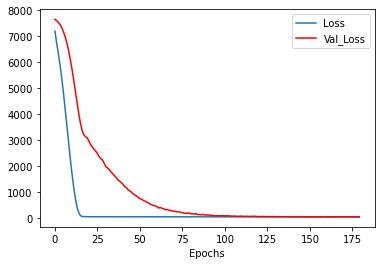

In [95]:
ax = plt.gca()

loss.plot(kind='line', y='Loss', xlabel = 'Epochs',ax=ax)
loss.plot(kind='line', y='Val_Loss', xlabel = 'Epochs', color='red', ax=ax)

loss.plot()           #to plot the loss values
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [90]:
model.summary()

Model: "functional_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 25, 3, 1)]        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 25, 3, 16)         160       
_________________________________________________________________
batch_normalization_33 (Batc (None, 25, 3, 16)         64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 3, 32)         4640      
_________________________________________________________________
batch_normalization_34 (Batc (None, 25, 3, 32)         128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 3, 64)         18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 25, 3, 64)       

In [49]:
predictions = model.predict(rest_in)

True_value = pd.DataFrame(rest_out)
True_value = True_value.reset_index(drop=True)
predected_value = pd.DataFrame(predictions)
Error = predected_value - True_value
Error = Error.abs()  # converts -ve numbers into +ve

compare = pd.concat([True_value,predected_value,Error],axis=1)
compare.columns = ['True_value','predected_value','Error']
Error.columns=['Error']


compare

,True_value,predected_value,Error
0,79.081219,79.757683,0.676464
1,76.42528,76.622086,0.196806
2,89.295564,89.456474,0.16091
3,87.713029,87.667473,0.045556
4,76.299458,76.559746,0.260288
5,88.997762,89.145943,0.148181
6,79.250736,79.452934,0.202198
7,83.792259,83.776703,0.015556
8,78.31581,78.256157,0.059653
9,82.68085,82.467896,0.212955


In [50]:
Error.max() 

Error    1.041418
dtype: object

In [51]:
mean_absolute_error(rest_out,predictions)

0.1876945547400488

In [52]:
np.sqrt(mean_squared_error(rest_out,predictions)) #RMS error

0.2711708308706636

In [57]:
#model.save('SoHCCCV Random %Data Low.h5')

In [54]:
#loss.to_excel("metricsRandom.xlsx")

In [55]:
#compare.to_excel("predictionsRandom.xlsx")

In [172]:
print(tf.__version__)

1.14.0
